# TP1 - Classification par Kppv

Dans ce TP, nous allons utiliser une partie de la base de visages “Labeled Faces in the Wild” provenant de http://vis-www.cs.umass.edu/lfw/. Cette base contient 5749 personnes et 13233 images de taille 62 x 47 pixels. Certaines personnes ne sont représentées qu’une seule fois tandis que d’autres sont représentées très souvent (plus de 80 fois). Nous utiliserons ici seulement 7 personnes représentées 1288 fois.

In [4]:
# Importer les librairies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from time import perf_counter 

## I- Chargement des données:

### Charger les données
Charger les donner, puis afficher les en utilisant la fonction plot_gallery()  fournie.

In [5]:
def plot_gallery(images):
# Affiche les 12 premières images contenues dans images
# images est de taille Nb imageNyNx
    plt.figure(figsize=(7.2, 7.2))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.show()


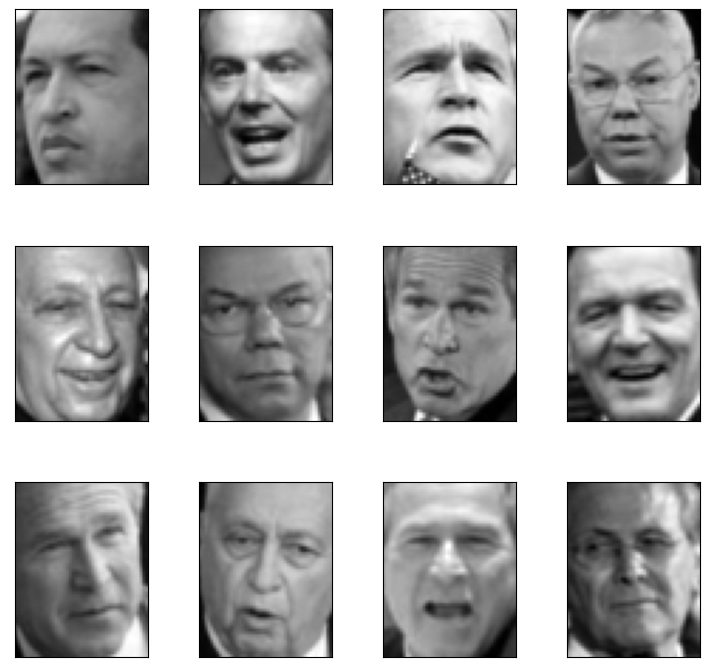

In [6]:
[X, y, name]=np.load("TP1.npy",allow_pickle=True )
plot_gallery(X)

#### Question

- Sachant que X représente les features, y les labels et name le nom des classes, déterminer la taille des images, le nombre d’images et le nombre de classes.

- Retrouver l’identité des 12 personnes affichées. Est-ce que les classes sont équiprobables ? 

- Retrouver le nombre d’exemples par classe. On pourra pour cela utiliser l’histogramme (plt.hist()).

**1. déterminons la taille des images, le nombre d’images et le nombre de classes.**

In [18]:
X.shape

(1288, 62, 47)

In [8]:
y.shape

(1288,)

In [9]:
name.shape

(7,)

In [14]:
print(f"taille des images: {X.ndim * y.ndim}")

taille des images: 3


In [15]:
print(f"nombre d'images : {len(np.unique(X))}")

nombre d'images : 766


In [17]:
print(f"nombre de classes : {len(np.unique(name))}")

nombre de classes : 7


1.b **Retrouvons l’identité des 12 personnes affichées. Est-ce que les classes sont équiprobables ?** 

In [38]:
X.shape[0]

1288

In [22]:
print(y[:12])

[5 6 3 1 0 1 3 4 3 0 3 2]


In [23]:
print(name[:12])

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [25]:
# l’identité des 12 personnes affichées
for i in y[:12]:
    print(name[i])

Hugo Chavez
Tony Blair
George W Bush
Colin Powell
Ariel Sharon
Colin Powell
George W Bush
Gerhard Schroeder
George W Bush
Ariel Sharon
George W Bush
Donald Rumsfeld


In [35]:
# Est-ce que les classes sont équiprobables ?
ens = set()
for i,j in enumerate(y):
    ens |= {(name[j], np.count_nonzero(y == j))}
ens
    

{('Ariel Sharon', 77),
 ('Colin Powell', 236),
 ('Donald Rumsfeld', 121),
 ('George W Bush', 530),
 ('Gerhard Schroeder', 109),
 ('Hugo Chavez', 71),
 ('Tony Blair', 144)}

In [41]:
# Count Occurrences of Each Unique Value
ens2 = set()
for i,j in enumerate(y):
    ens2 |= {(name[j], (np.count_nonzero(y == j))/X.shape[0])}
ens2

{('Ariel Sharon', 0.059782608695652176),
 ('Colin Powell', 0.18322981366459629),
 ('Donald Rumsfeld', 0.09394409937888198),
 ('George W Bush', 0.4114906832298137),
 ('Gerhard Schroeder', 0.08462732919254658),
 ('Hugo Chavez', 0.05512422360248447),
 ('Tony Blair', 0.11180124223602485)}

In [73]:
import pandas as pd
mydf = pd.DataFrame(ens2)

In [74]:
mydf.columns = ['name','probability']
mydf

,name,probability
0,Hugo Chavez,0.055124
1,Colin Powell,0.183230
2,Gerhard Schroeder,0.084627
3,Ariel Sharon,0.059783
4,George W Bush,0.411491
5,Tony Blair,0.111801
6,Donald Rumsfeld,0.093944


In [55]:
import matplotlib
%matplotlib inline

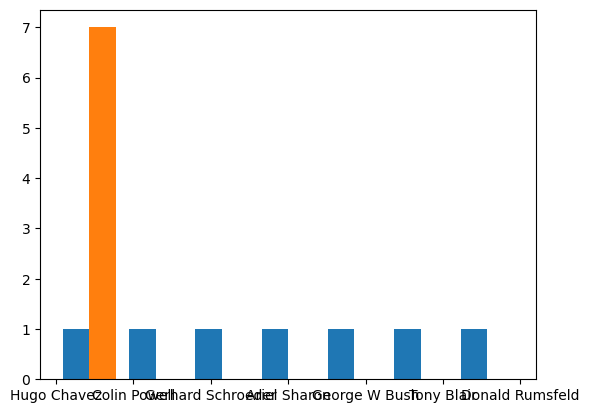

In [82]:
plt.hist(mydf, bins=7)
plt.show()

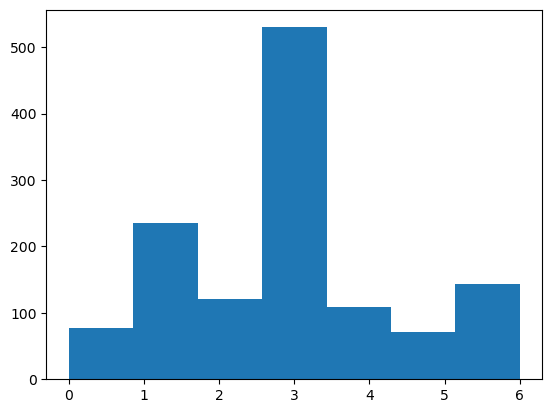

In [79]:
plt.hist(y,bins=7)
plt.show()

### Partitionnement de la base d’apprentissage

Partitionner la base en une base d’apprentissage et une base de test en mettant 25% des données
en test (fonction train_test_split()) pour obtenir les variables X_train, X_test, y_train et y_test.

In [76]:
from sklearn.preprocessing import LabelEncoder

In [77]:
X_encoder, Y_encoder = LabelEncoder(), LabelEncoder()

In [85]:
X = X_encoder.fit_transform(X)
y = Y_encoder.fit_transform(y.values().ravel())

ValueError: y should be a 1d array, got an array of shape (1288, 62, 47) instead.

#### Question
- Combien y a-t-il d’images en train et en test ? 
- Quelles sont les dimensions des quatre variables X_train, X_test, y_train et y_test ?

## II. Prétraitement des données:

### Redimensionnement des données

Pour réaliser une classification par kppv, on utilise un codage rétinien. Chaque image est donc représentée par un vecteur de caractéristique de dimension 𝑛 = 2914. Redimensionner X_train et X_test de façon à ce qu’ils aient pour dimension 𝑁 x 𝑛 (np.reshape()) où N est le nombre d’exemples.

### Mise en forme des données pour la classification

Mettre en forme les données (train et test) en utilisant la classe StandardScaler. On estimera la moyenne et l’écart-type de chaque dimension sur les données d’apprentissage, puis on transformera les données (train et test) en utilisant ces valeurs. Aller sur la documentation en
ligne de StandardScaler pour voir quelle méthode de cette classe utiliser.

#### Question
- A quoi consiste la mise en forme des données ? 

- Comment sont-elles transformées ?

## III. Classification par les KPPV:

### Classifieur 1PPV

- Définir le classifieur 1PPV en utilisant la classe KNeighborsClassifier(). On souhaite utiliser la distance euclidienne et le 1PPV. 

- Train le classifieur sur X_train, y_train.

- Réaliser la classification des exemples de test en utilisant la méthode predict().

#### Questions 
- Que représente la matrice de confusion ?
- Que vaut sa somme ? 
- Est-ce que les classes sont équilibrées ?



Afficher la matrice de confusion (fonction confusion_matrix()) et estimer le taux dereconnaissance à partir des éléments de cette matrice. Vérifier que le taux est identique à celui renvoyé par la fonction accuracy_score().

### Classifieur KPPV
Faire varier le K des KPPV et tracer l’évolution du taux de reconnaissance en fonction de K.

#### Questions :

Conclusion ? Interpréter l’évolution des résultats en fonction de K

### Classifieur KPPV et distance de Manhattan

Réaliser les mêmes tests avec la distance de Manhattan.

#### Questions :
- Conclusion ? Interpréter l’évolution des résultats en fonction de K.
- Pour résoudre ce problème de classification, quelle distance et valeur de K choisissez-vous suite à ces tests ?

# TP2: Analyse en composantes principales, classification et reconstruction :



## I. Chargement et mise en forme des données:

On utilisera les mêmes données que lors du TP1 avec leur redimensionnement et leur mise en forme.

#### Questions

- Combien y a-t-il de données en apprentissage et en test ?
- Quelle est la dimension des données après redimensionnement ?


## II. Analyse en composantes principales et classification

1. Définissez la décomposition en composantes principales en utilisant la fonction PCA() en gardant le maximum de composantes, ajuster le modèle sur X_train (   ) puis tracer les variances en utilisant l’attribut pca.explained_variance_ratio_  


2. Redéfinissez la décomposition en utilisant la fonction   en conservant 100 composantes, ajuster le modèle sur X_train, puis transformez les données X_train et X_test pour obtenir X_train1 et X_test1.

3. Réaliser la classification sur les données de départ puis sur les nouvelles données avec la méthode du 5PPV et la distance de Manhattan. Conclure sur le taux de reconnaissance et les temps de calcul qui peuvente être déterminés par :



```
from time import perf_counter
 tps1 = perf_counter()
 tps2 = perf_counter()
 print("Durée de classification",tps2 - tps1)
```



#### Questions :

- Que représentent les valeurs renvoyées par pca.explained_variance_ratio_ ? 

- Observer la taille de X_train1 et X_test1. Quelle est la nouvelle dimension des données ?
- Comment varient les temps de calcul entre une classification avec ou sans ACP ?
- Comment varient les taux de reconnaissance ?

## III. Analyse en composantes principales et reconstruction

Le but est de compresser les images afin qu’elle prenne moins de place en mémoire. On va donc définir sur X_train la façon de compresser. Puis on comprimera et décomprimera les images de X_test afin de voir les pertes induites par la compression.

- Définissez la décomposition en composantes principales en utilisant la fonction PCA() en conservant 50 composantes et ajuster le modèle sur X_train.


- Récupérer les vecteurs propres en utilisant un attribut de PCA(). 

- Redimensionner les vecteurs propres en images propres (np.reshape()) de manière à pourvoir les visualiser sous forme d’images (array de taille 50x62x47). On utilisera la fonction plot_gallery() pour la visualisation.

Questions:

- Que représentent les vecteurs propres ?
- Quelle est leur taille ?

Les vecteurs propres représentent: 

Les axes principaux dans l'espace d'entités, représentant les directions de variance maximale dans les données. Les composants sont triés par explication_variance_.

- On souhaite comprimer les images de X_test afin de les transmettre en utilisant le moins de bande passante possible. Pour cela, les 50 images propres sont transmises une fois. Pour chaque nouvelle image, on transmet uniquement ses composantes dans le nouveau système d’axe de dimension 50. L’image est ensuite reconstruite à l’arrivée.
Appliquer l’ACP des images de X_test (X_testC)

- Reconstruisez les images à partir X_testC pour obtenir les images X_testR à partir d’une
des méthodes de PCA(). Afficher les images reconstruites et les comparer visuellement
aux images de départ.

-  Comparer les images initiales et reconstruites de manière quantitative en faisant la
moyenne des distances euclidiennes :


```
E= (X_testR-X_test)**2
E = np.mean(np.sqrt(np.sum(E,axis=0)))
```

Questions: 

- Comparer les tailles de X_test et X_testC et en déduire le taux de compression.
- Observer la taille de X_testR. Quel est le principe de la reconstruction des images ?

- Comment passe-t-on de X_testC à X_testR ?

- Faire varier le nombre de composantes conservées de 10 à 950 par pas de 50 et calculer l’erreur de reconstruction. Afficher l’erreur de reconstruction en fonction du nombre de composantes.

- Comment varie l’erreur de reconstruction en fonction du nombre de composantes ? 
- Comparer visuellement les images initiales et reconstruites à partir de 950
composantes. Conclusion ?